In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import os
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
path = 'Chest X-Ray'

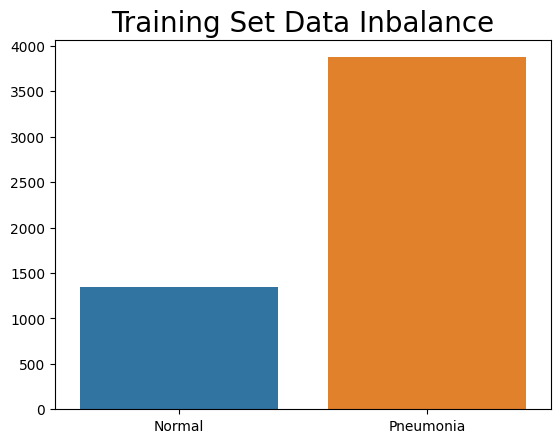

In [3]:
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/train/NORMAL', filename) 
                     for filename in os.listdir(path+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

In [4]:

transformer = {
    'dataset1': transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(),
                                            transform.RandomRotation(10),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transform.ToTensor()
                                           ]),
    
    'dataset2' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=1),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.1,0.05), degrees=10),
                                            transform.ToTensor()
                                    
                                           ]),
    'dataset3' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=0.5),
                                            transform.RandomRotation(15),
                                            transform.RandomGrayscale(p=1),
                                            transform.RandomAffine(translate=(0.08,0.1), degrees=15),
                                            transform.ToTensor()
                                           ]),
}

In [5]:
dataset1 = ImageFolder(path+'/train', 
                      transform=transformer['dataset1'])

dataset2 = ImageFolder(path+'/train', 
                      transform=transformer['dataset2'])

dataset3 = ImageFolder(path+'/train', 
                      transform=transformer['dataset3'])

norm1, _ = train_test_split(dataset2, test_size= 3875/(1341+3875), shuffle=False)
norm2, _ = train_test_split(dataset3, test_size= 4023/(1341+3875), shuffle=False)

dataset = ConcatDataset([dataset1, norm1, norm2])

len(dataset)

7750

In [6]:
print(dataset1.classes)


['NORMAL', 'PNEUMONIA']


In [7]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

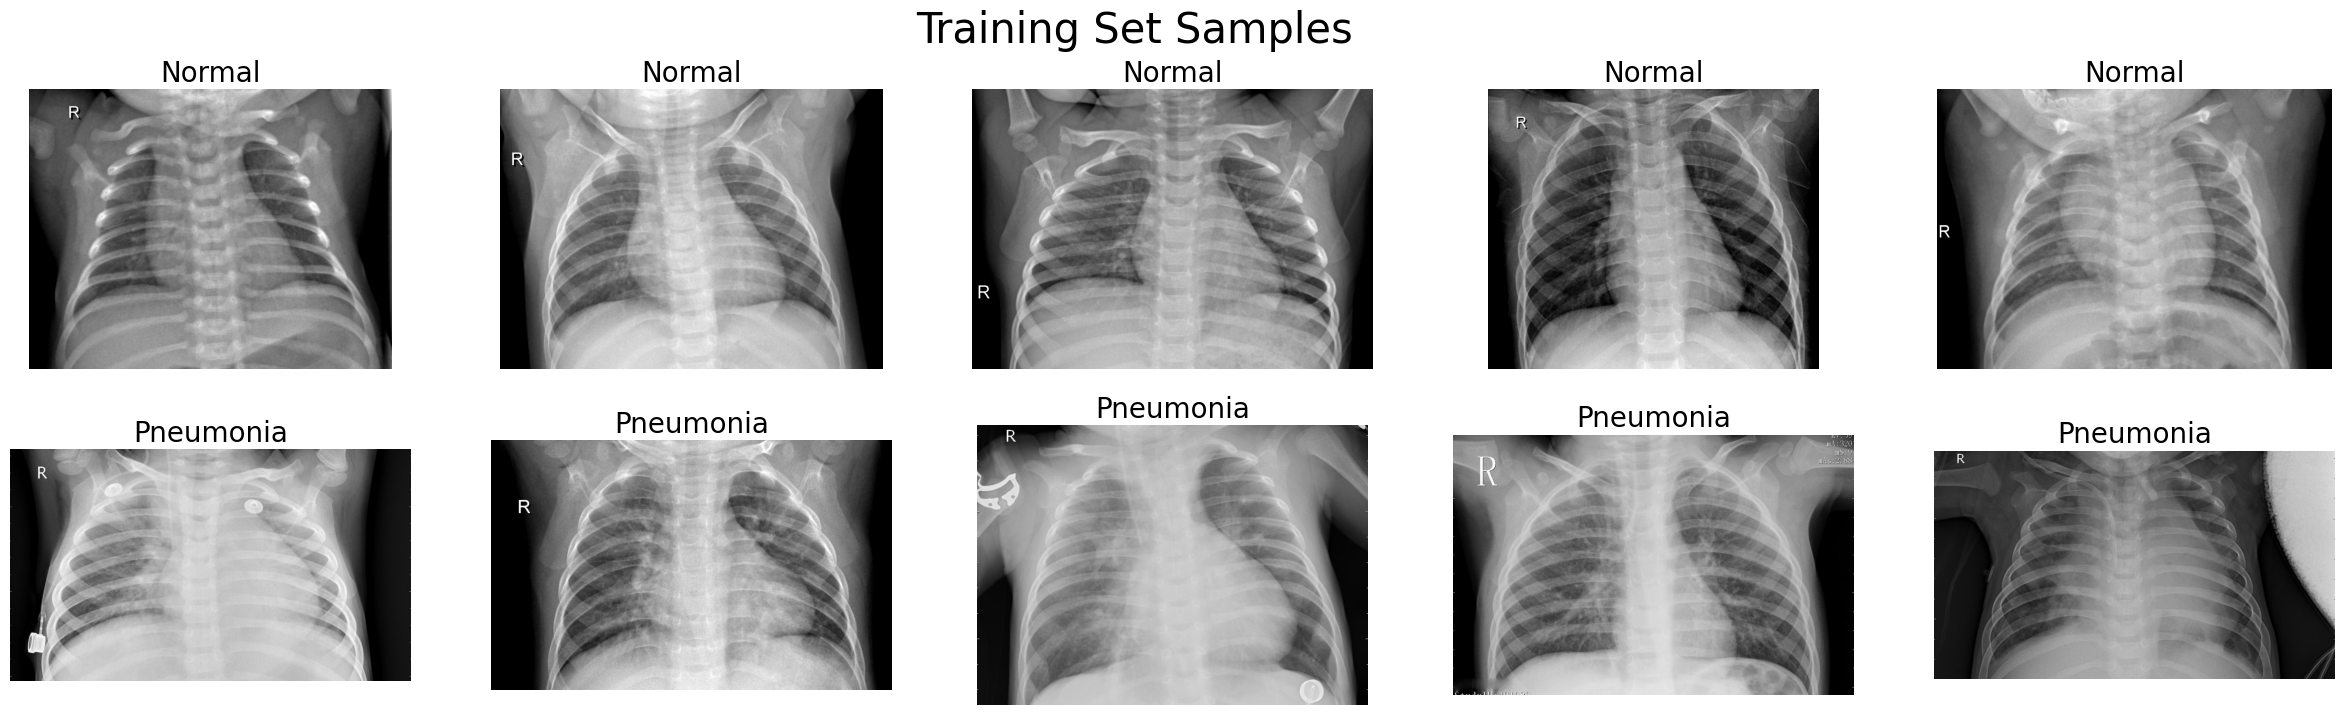

In [8]:
rand_samples = random.sample([os.path.join(path+'/train/NORMAL', filename) 
                              for filename in os.listdir(path+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(path+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(path+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

In [9]:
# set random seed so we get the same sampling every time for reproducibility

random_seed = 2020
torch.manual_seed(random_seed)

In [10]:
train_ds, val_ds = train_test_split(dataset, test_size=0.3, random_state=random_seed)
len(train_ds), len(val_ds)

(5425, 2325)

In [11]:
batch_size=32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
loaders = {'train':train_dl, 'val':val_dl}
dataset_sizes = {'train':len(train_ds), 'val':len(val_ds)}

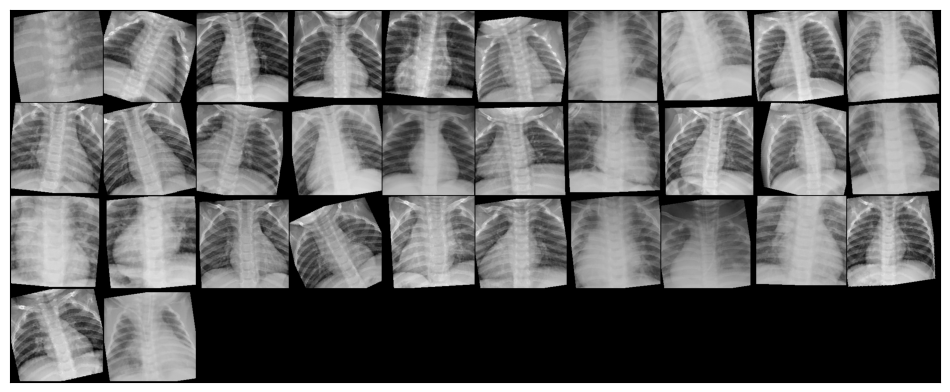

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [14]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

In [36]:
model2 = load_checkpoint('./PneumoniaDensnet_partialFineTune.pth')
model2.to(device)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [37]:
def validation_step(batch, model):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        out = model(images)                                      
        loss = F.cross_entropy(out, labels)                    
        acc,preds = accuracy(out, labels)                       
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}

In [38]:
def test_prediction(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()             
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}  

In [39]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [validation_step(batch,model) for batch in test_loader] 
    results = test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [40]:
testset = ImageFolder(path+'/test', 
                    transform=transform.Compose([transform.Resize(255),
                    transform.CenterCrop(224),                                                              
                    transform.ToTensor(),]))

test_dl = DataLoader(testset, batch_size=256)
model2.to(device)
preds,labels = test_predict(model2, test_dl)

TypeError: 'numpy.float64' object is not callable

<Figure size 640x480 with 0 Axes>

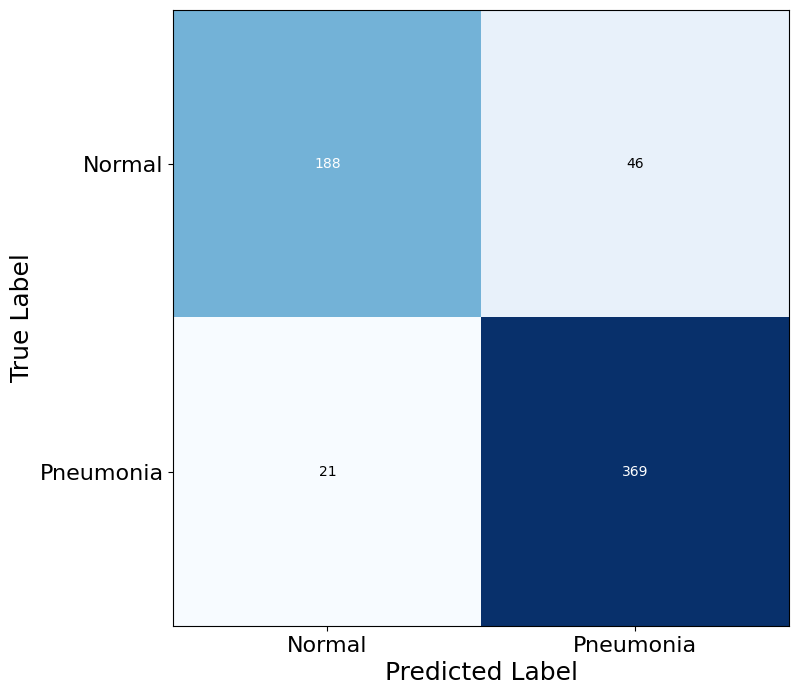

In [ ]:
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [ ]:
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.89
Recall of the model is 0.95
Precision of the model is 0.89
F1 Score of the model is 0.92


In [14]:
model = torchvision.models.densenet161(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier.in_features

model.classifier = nn.Linear(in_features, 2)

C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}


In [17]:
def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model  

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
model.to(device)
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

In [19]:
model.to(device)
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/10
train - loss:0.3022445633224628, accuracy0.8894009216589862
val - loss:0.16141799455047937, accuracy0.9561290322580646
Time: 0.0m 54.27335739135742s
Epoch: 2/10
train - loss:0.1619759381813113, accuracy0.9434101382488479
val - loss:0.1539754203987378, accuracy0.9423655913978495
Time: 1.0m 42.64348268508911s
Epoch: 3/10
train - loss:0.13866383181738964, accuracy0.9550230414746543
val - loss:0.11373445119107924, accuracy0.9608602150537634
Time: 2.0m 32.59654784202576s
Epoch: 4/10
train - loss:0.12358130356133808, accuracy0.9541013824884793
val - loss:0.10454552508009378, accuracy0.9638709677419355
Time: 3.0m 20.132940530776978s
Epoch: 5/10
train - loss:0.10760305011602041, accuracy0.9640552995391705
val - loss:0.10283773421119619, accuracy0.9638709677419355
Time: 4.0m 8.167559146881104s
Epoch: 6/10
train - loss:0.10375481072658767, accuracy0.9664516129032258
val - loss:0.10511886073777112, accuracy0.9625806451612903
Time: 4.0m 55.92333984375s
Epoch: 7/10
train - loss:0.103274

In [22]:
# Save Model
bestmodel = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(bestmodel, 'PneumoniaDensnet.pth')

In [4]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

In [5]:
model2 = load_checkpoint('./PneumoniaResnet.pth')
model2.to(device)
model2

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

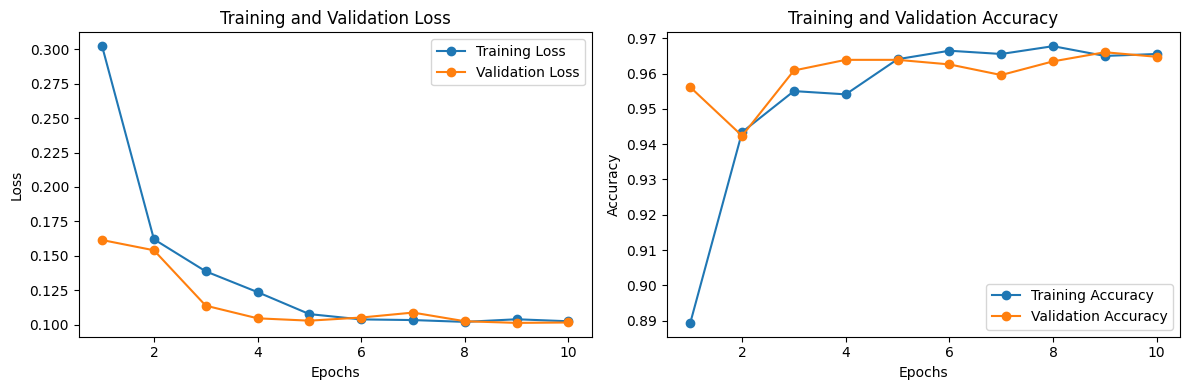

In [30]:
import matplotlib.pyplot as plt

def plot_training_history(losses, accuracies):
    epochs = range(1, len(losses['train']) + 1)

    # Convert tensor values in 'accuracies' to numpy and move them to CPU
    accuracies['train'] = [acc.cpu().numpy() for acc in accuracies['train']]
    accuracies['val'] = [acc.cpu().numpy() for acc in accuracies['val']]

    # Plotting loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses['train'], label='Training Loss', marker='o')
    plt.plot(epochs, losses['val'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies['train'], label='Training Accuracy', marker='o')
    plt.plot(epochs, accuracies['val'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# To plot the training history after training your model
plot_training_history(losses, accuracies)
